# Advantage Actor Critic (A2A) with CartPole

Actor Critic methods are a cross-over between policy-based and value-based methods. Policy-based methods aim to directly learn an optimal policy by maximising an objective function related to the performance of the agent in an environment, whilst value-based methods first try to estimate the future reward of each state-action pair in the environment and indirectly learn an optimal policy through these action-values. Both of these methods have their drawbacks: 

#### Value-based:
    - Works well with a finite action-space, but does not scale to large action-spaces.
    - Often do not converge, as a small change in value-space can cause a large deviation in policy-space.
    
#### Policy-based:
    - Directly optimising in policy-space results in smoother learning, but tends to converge towards local-minima.
    - Suffers from high variance as updates occur on an episodic basis. 
    - Often slow to learn.
    
By combining these approaches, some of the problems that come with the individual approaches can be alleviated. 

In actor-critic methods, there are two separate models. One model, known as the critic, is used to estimate the action-values of the environment. The other model, known as the actor, is used to learn a policy-function with the help of the action-values learned by the critic. Since the policy-updates can occur during the episode, using bootstrapped values obtained by the critic, the overall variance of the agent is reduced. As a result, the actor-critic methods are often faster than policy-based methods alone and have nicer convergence properties than value-based methods. Additionally, actor-critic methods can be used when the action space is continuous and are able to learn stochastic policies.

#### Import necessary modules

In [48]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from actor_critic import ActorCritic, Agent

#### Set up the CartPole environment and hyperparameters for the agent + networks

In [43]:
# Set up the CartPole Environment.
env = gym.make("CartPole-v0")

# Retrieve the state space and action space objects for CartPole.
state_space = env.observation_space
action_space = env.action_space
p_hidden_size = 32
v_hidden_size = 32

episodes = 1000
discount = 0.99

runs = 50

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


#### Run experiments (50 experiments for learning CartPole over 1000 episodes)

In [ ]:
run_rewards = []

# For the number of experiments set
for run in range(runs):
    
    # Instantiate the actor-critic model
    model = ActorCritic(state_space, action_space, p_hidden_size, v_hidden_size)
    
    # Instantiate the agent
    agent = Agent(model)

    # Set up the loss function and optimiser for the NNs.
    optimiser = torch.optim.RMSprop(model.parameters())
    
    # Cache the episodic rewards
    episode_rewards = []

    # For each episode in a run.
    for episode in range(episodes):
        # Reset the policy and value history of the agent.
        agent.reset_history()
        
        # Reset the environment and store the initial state
        state = torch.Tensor(env.reset())

        # Store the total reward of an episode
        total_reward = 0
        
        # Set boolean flag to say whether the episode has ended or not.
        done = False
        
        # Whilst the episode has not finished.
        while not done:
            
            # Use the agent's policy to select an action, given a state.
            action = agent.select_move(state)
            
            # Perform the selected action in the environment and receive
            # the next state, reward, and whether the episode is finished.
            next_state, reward, done, info = env.step(action.data.numpy())

            # Cache the reward at time t
            agent.policy_reward.append(reward)

            # Set the current state to the next state.
            state = torch.Tensor(next_state)
            
            # Update the total reward.
            total_reward += reward

        # Cache the total reward of the episodes
        episode_rewards.append(total_reward)
        
        # Cache the discounted rewards at each step of the episode
        rewards = []
        R = 0

        # Calculate the discounted reward at each step of the episode.
        for r in agent.policy_reward[::-1]:
            R = r + discount * R
            rewards.insert(0, R)

        # Normalise the rewards for stability.
        rewards = torch.FloatTensor(rewards).view(-1, 1)
        rewards = (rewards - rewards.mean()) / (rewards.std())

        # Retrieve the log probabilities of the actions over time.
        log_pi_t = agent.policy_history
        
        # Retrieve the values of each state over time.
        v_s_t = agent.value_history
        
        # Calculate the advantage.
        advantage = rewards - v_s_t

        # Calculate the policy loss
        policy_loss = (-log_pi_t * advantage.detach()).mean()

        # Calculate the value loss (MSE)
        value_loss = advantage.pow(2).mean()
        
        # Combine the two losses together
        loss = policy_loss + 0.5 * value_loss        

        # Zero the gradients in the optimiser
        optimiser.zero_grad()

        # Retrieve gradients of the loss with respect to the networks' parameters.
        loss.backward()

        # Take a gradient descent step.
        optimiser.step()
    
    # Cache the episodic rewards over each run.
    run_rewards.append(episode_rewards)


#### Plot the moving average of the agent over a number of episodes

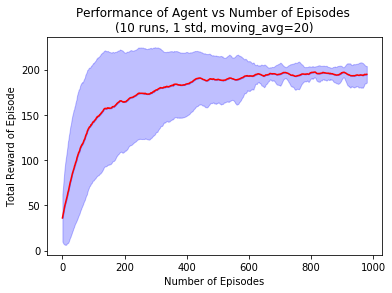

In [45]:
%matplotlib inline
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

means = np.mean([moving_average(rewards) for rewards in run_rewards], axis=0)
stds = np.std([moving_average(rewards) for rewards in run_rewards], axis=0)

plt.plot(range(len(means)), means, color='red')

plt.fill_between(range(len(means)), means, means + stds, color='blue', alpha=.25)
plt.fill_between(range(len(means)), means, means - stds, color='blue', alpha=.25)

plt.title('Performance of Agent vs Number of Episodes \n(10 runs, 1 std, moving_avg=20)')
plt.xlabel('Number of Episodes')
plt.ylabel('Total Reward of Episode')

plt.show()